# Training

## Process Data

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os

import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np

from tqdm.notebook import tqdm

In [ ]:
import json
import ast
from currency_converter import CurrencyConverter
c = CurrencyConverter()
import pandas as pd
DATAPATH = './Data'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.6/563.6 KB 9.9 MB/s eta 0:00:00


In [ ]:
n_pages = 40
for i in range(n_pages):
    if i ==0:
        sampleData = pd.read_csv(os.path.join(DATAPATH, f'{i}.csv'))
    else:
        sampleData = sampleData.append(pd.read_csv(os.path.join(DATAPATH, f'{i}.csv')))
        print(sampleData.shape)
sampleData.shape

def moneyConversion(fromCurrency, fromAmt, to= "USD"):
    ret = c.convert(fromAmt, fromCurrency, to)
    return ret

extractedDf = sampleData[["price_overview", "developers", "categories", "genres", "recommendations"]].copy()
extractedDf = extractedDf.dropna()
attributes = pd.DataFrame(extractedDf.iloc[:, :4])
label = pd.DataFrame(extractedDf.iloc[:, -1])

retDf = pd.DataFrame({'Currency(USD)':[], 'Categories(ID)':[], 'Genres(ID)':[], 'Label(Binary Classification)':[], 'Label(Regression)':[]})

for i in tqdm(range(len(label))):
    attributesElement = attributes.iloc[i]

    priceRaw = attributesElement["price_overview"]
    priceRaw = ast.literal_eval(priceRaw)
    currencyInUS = [round(moneyConversion(priceRaw['currency'], priceRaw['final']/100),2)]

    developers = attributesElement['developers'][1:-1]

    categories = attributesElement['categories']
    categories = ast.literal_eval(categories)
    categoriesID = np.array(list(i['id'] for i in categories))

    genres = attributesElement['genres']
    genres = ast.literal_eval(genres)
    genresID = np.array(list(int(i['id']) for i in genres))

    labelElement = label.iloc[i]['recommendations']

    labelRaw = ast.literal_eval(labelElement)
    labelRawRegression = labelRaw['total']
    labelRawClassification = 1 if labelRaw['total'] > 560 else 0

    retDf = retDf.append({'Currency(USD)':currencyInUS, 'Categories(ID)':categoriesID, 'Genres(ID)':genresID, 'Label(Binary Classification)':labelRawClassification, 'Label(Regression)':labelRawRegression}, ignore_index= True)

store = retDf['Categories(ID)'].apply(max)
max_num = max(store)
tmpStore = retDf['Genres(ID)'].apply(max)
max_num_genres = max(tmpStore)

for i in range(len(retDf)):
    tmpEnc = [0] * max_num
    element = retDf.iloc[i]['Categories(ID)']
    for j in element:
        tmpEnc[j - 1] = 1

    tmpEncGenres = [0] * int(max_num_genres)
    elementGenres = retDf.iloc[i]['Genres(ID)']
    for j in elementGenres:
        tmpEncGenres[int(j)-1] = 1

    retDf.loc[i, ['Categories(ID)', 'Genres(ID)']] = [tmpEnc, tmpEncGenres]

retDf['Encoding'] = retDf["Currency(USD)"] + retDf['Categories(ID)'] + retDf['Genres(ID)']


(2000, 39)
(3000, 39)
(4000, 39)
(5000, 39)
(6000, 39)
(7000, 39)
(8000, 39)
(9000, 39)
(10000, 39)
(11000, 39)
(12000, 39)
(13000, 39)
(14000, 39)
(15000, 39)
(16000, 39)
(17000, 39)
(18000, 39)
(19000, 39)
(20000, 39)


  0%|          | 0/9229 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


(array([4343., 1515.,  670.,  466.,  291.,  234.,  175.,  120.,  103.,
          82.,  102.,   55.,   59.,   54.,   44.,   42.,   39.,   48.,
          35.]),
 array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000., 5500., 6000., 6500., 7000., 7500., 8000., 8500.,
        9000., 9500.]),
 <BarContainer object of 19 artists>)

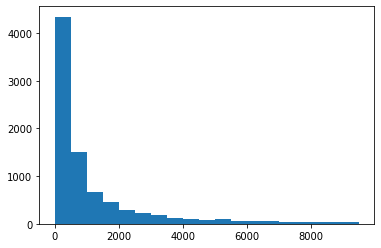

In [ ]:
import matplotlib.pyplot as plt
plt.hist(retDf['Label(Regression)'], bins = np.arange(0,1e4, 500))

## Process Data V2

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os

import random

import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np

from tqdm.notebook import tqdm

In [ ]:
import json
import ast
import math
import re
from currency_converter import CurrencyConverter
c = CurrencyConverter()
import pandas as pd
DATAPATH = './Data'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


In [ ]:
n_pages = 52
for i in tqdm(range(n_pages)):
    if i == 0:
        sampleData = pd.read_csv(os.path.join(DATAPATH, f'{i}.csv'))
    else:
        sampleData = sampleData.append(pd.read_csv(os.path.join(DATAPATH, f'{i}.csv')))
sampleData = sampleData.reset_index()
sampleData.columns


  0%|          | 0/52 [00:00<?, ?it/s]

Index(['index', 'type', 'name', 'steam_appid', 'required_age', 'is_free',
       'controller_support', 'dlc', 'detailed_description', 'about_the_game',
       'short_description', 'fullgame', 'supported_languages', 'header_image',
       'website', 'pc_requirements', 'mac_requirements', 'linux_requirements',
       'legal_notice', 'drm_notice', 'ext_user_account_notice', 'developers',
       'publishers', 'demos', 'price_overview', 'packages', 'package_groups',
       'platforms', 'metacritic', 'reviews', 'categories', 'genres',
       'screenshots', 'movies', 'recommendations', 'achievements',
       'release_date', 'support_info', 'background', 'content_descriptors'],
      dtype='object')

In [ ]:
extractedDf = sampleData[["required_age",
                          "controller_support",
                          "dlc",
                          "supported_languages",
                          "pc_requirements",
                          "developers",
                          "platforms",
                          "release_date",
                          "is_free",
                          "price_overview",
                          "categories",
                          "genres",
                          "recommendations"]].copy()
extractedDf.loc[(extractedDf["price_overview"].isna()) & (extractedDf["is_free"]==True),'price_overview'] =   "{'currency':'USD', 'final':0}"


extractedDf['dlc'] = extractedDf['dlc'].fillna(0)

extractedDf['controller_support'] = extractedDf['controller_support'].fillna(0)
extractedDf = extractedDf.dropna()
extractedDf.shape

(10993, 13)

In [ ]:
def moneyConversion(fromCurrency, fromAmt, to= "USD"):
    ret = c.convert(fromAmt, fromCurrency, to)
    return ret

attributes = pd.DataFrame(extractedDf.iloc[:, :12])
label = pd.DataFrame(extractedDf.iloc[:, -1])


retDf = pd.DataFrame({'Required_Age':[],
                      'Controller_support':[],
                      'DLC':[],
                      'Supported_languages':[],
                      'PC_Requirements':[],
                      'Developers':[],
                      'Platforms':[],
                      'Release_year':[],
                      'Currency(USD)':[],
                      'Categories(ID)':[],
                      'Genres(ID)':[],
                      'Label(Binary Classification)':[],
                      'Label(Regression)':[]})

for i in tqdm(range(len(extractedDf))):
    attributesElement = attributes.iloc[i]

    if  type(attributesElement['required_age']) == str:
        age = int(re.sub('[^0-9]','', attributesElement['required_age']))
    else:
        age = int(attributesElement['required_age'])

    if attributesElement['controller_support'] == 'full':
        controler = 1
    else:
        controler = 0

    if attributesElement['dlc'] != 0 :
        num_dlc = len(ast.literal_eval(attributesElement['dlc']))
    else:
        num_dlc = 0

    languages = attributesElement['supported_languages'].replace('<strong>*</strong>', '')
    languages = languages.replace('<br>', '')
    languages = len(languages.split(','))

    req = attributesElement['pc_requirements'].lower()
    req = re.sub("\<.*?\>"," ",req)
    req = req.replace('\'', ' ')
    req = req.replace(',', ' ')
    req = req.replace('\\r', ' ')
    req = req.replace('\\n', ' ')
    req = req.replace('\\t', ' ')
    req = req.split(' ')
    req = list(filter(('').__ne__, req))
    proc = None
    if 'processor:' in req:
        procIdx = req.index('processor:')
        proc = ''.join(req[procIdx: procIdx + 6])
        if 'hz' in proc:
            proc = proc[proc.index('hz')-4 :proc.index('hz')+2]
        else:
            proc = None
    elif 'processor' in req:
        procIdx = req.index('processor')
        proc = ''.join(req[procIdx - 2:procIdx+1])
        if 'hz' in proc:
            proc = proc[proc.index('hz')-4 :proc.index('hz')+2]
        else:
            proc = None

    ram = None
    if 'memory:' in req and 'ram' in req:
        ramIdx = req.index('ram')
        ram = ''.join(req[ramIdx: ramIdx + 5])
        if 'mb' in ram:
            ram = ''.join(ram[ram.index('mb') - 3:ram.index('mb') + 2])
        elif 'gb' in ram:
            ram = ''.join(ram[ram.index('gb') - 3:ram.index('gb') + 2])
        else:
            ram = None
    elif 'ram' in req:
        ramIdx = req.index('ram')
        ram = ''.join(req[ramIdx: ramIdx + 5])
        if 'mb' in ram:
            ram = ''.join(ram[ram.index('mb') - 3:ram.index('mb') + 2])
        elif 'gb' in ram:
            ram = ''.join(ram[ram.index('gb') - 3:ram.index('gb') + 2])
        else:
            ram = None
    if ram:
        ram = re.findall('[0-9]+.b', ram)
        ram = ram[0] if len(ram)>0 else None


    requirements = [proc, ram]


    developers = attributesElement['developers'][1:-1]

    platform = ast.literal_eval(attributesElement['platforms'])
    num_plat = 0
    for k, v in platform.items():
        if v == True:
            num_plat += 1

    if len(ast.literal_eval(attributesElement['release_date'])['date'])>0:
        try:
            year = int(ast.literal_eval(attributesElement['release_date'])['date'].split(",")[-1])
        except:
            try:
                year = int(ast.literal_eval(attributesElement['release_date'])['date'].split(" ")[-1])
            except:
                year = None
                for y in ast.literal_eval(attributesElement['release_date'])['date'].split(" "):
                    if len(y) == 4 and y.isnumeric():
                        year = int(y)
                        continue
                if year == None: raise
    else:
        year = 0

    priceRaw = attributesElement["price_overview"]
    priceRaw = ast.literal_eval(priceRaw)

    try:
        currencyInUS = round(moneyConversion(priceRaw['currency'], priceRaw['final']/100),2)
    except:
        if priceRaw['currency'] == 'TWD':
            mult = 0.035
        currencyInUS = round(mult * priceRaw['final']/100, 2)


    categories = attributesElement['categories']
    categories = ast.literal_eval(categories)
    categoriesID = np.array(list(i['id'] for i in categories))

    genres = attributesElement['genres']
    genres = ast.literal_eval(genres)
    genresID = np.array(list(int(i['id']) for i in genres))

    labelElement = label.iloc[i]['recommendations']

    labelRaw = ast.literal_eval(labelElement)
    labelRawRegression = labelRaw['total']
    labelRawClassification = 1 if labelRaw['total'] > 560 else 0

    retDf = retDf.append({'Required_Age':age,
                      'Controller_support':controler,
                      'DLC':num_dlc,
                      'Supported_languages':languages,
                      'PC_Requirements':requirements,
                      'Developers':developers,
                      'Platforms':num_plat,
                      'Release_year':year,
                      'Currency(USD)':currencyInUS,
                      'Categories(ID)':categoriesID,
                      'Genres(ID)':genresID,
                      'Label(Binary Classification)':labelRawClassification,
                      'Label(Regression)':labelRawRegression},
                      ignore_index= True)


retDf.loc[retDf['Release_year']==0, 'Release_year'] = retDf['Release_year'].median()
retDf.loc[retDf['Currency(USD)'] > 99.99, 'Currency(USD)']  = 99.99

  0%|          | 0/10993 [00:00<?, ?it/s]

In [ ]:
store = retDf['Categories(ID)'].apply(max)
max_num = max(store)
tmpStore = retDf['Genres(ID)'].apply(max)
max_num_genres = max(tmpStore)

for i in tqdm(range(len(retDf))):
    tmpEnc = [0] * max_num
    element = retDf.iloc[i]['Categories(ID)']
    for j in element:
        tmpEnc[j - 1] = 1

    tmpEncGenres = [0] * int(max_num_genres)
    elementGenres = retDf.iloc[i]['Genres(ID)']
    for j in elementGenres:
        tmpEncGenres[int(j)-1] = 1
    retDf.loc[i, ['Categories(ID)', 'Genres(ID)']] = [tmpEnc, tmpEncGenres]

  0%|          | 0/10993 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [ ]:
retDf['Req_Age'] = retDf['Required_Age']
retDf['Req_Age']  = [list(onehot) for onehot in pd.get_dummies(retDf['Req_Age']).values]
retDf['Req_Age']
# enc_len = int(retDf['Req_Age'].max()-retDf['Req_Age'].min())
# enc_min = int(retDf['Req_Age'].min())

# def judge(x):
#     digit = int(x - enc_min)
#     l = list([1]*(digit)+[0]*(enc_len-digit))
#     return l

# retDf['Req_Age'] = retDf['Req_Age'].apply(judge)
np.array(list(retDf['Req_Age'].values)).shape

(10993, 12)

In [ ]:
retDf['Plat'] = retDf['Platforms']
enc_len = int(retDf['Plat'].max()-retDf['Plat'].min())
enc_min = int(retDf['Plat'].min())

def judge(x):

    digit = int(x - enc_min)
    l = list([1]*(digit)+[0]*(enc_len-digit))
    return l

retDf['Plat'] = retDf['Plat'].apply(judge)
np.array(list(retDf['Plat'].values)).shape

(10993, 2)

In [ ]:
retDf['Dlc_cat'] = retDf['DLC']
enc_len = int(retDf['Dlc_cat'].max()-retDf['Dlc_cat'].min())
enc_mean = int(retDf['Dlc_cat'].mean())

def judge(x):
    enc_len = 2

    if x < enc_mean:
        x = 0
    elif x == enc_mean:
        x = 1
    else:
        x = 2

    digit = int(x - 0)
    l = list([1]*(digit)+[0]*(enc_len-digit))
    return l

retDf['Dlc_cat'] = retDf['Dlc_cat'].apply(judge)
np.array(list(retDf['Dlc_cat'])).shape

(10993, 2)

In [ ]:
retDf['Con_sup'] = retDf['Controller_support']
enc_len = int(retDf['Con_sup'].max()-retDf['Con_sup'].min())
enc_min = retDf['Con_sup'].min()

def judge(x):
    digit = int(x - enc_min)
    l = list([1]*(digit)+[0]*(enc_len-digit))
    return l

retDf['Con_sup'] = retDf['Con_sup'].apply(judge)
np.array(list(retDf['Con_sup'])).shape

(10993, 1)

In [ ]:
retDf['price'] = retDf['Currency(USD)']
enc_len = int(retDf['price'].max()-retDf['price'].min())
enc_min = retDf['price'].min()

def judge(x):
    digit = int(x - enc_min)

    l = list([1]*(digit//10)+[0]*(enc_len//10-digit//10))

    return l

retDf['price'] = retDf['price'].apply(judge)
np.array(list(retDf['price'])).shape

(10993, 9)

In [ ]:
retDf['Rel_year'] = retDf['Release_year']
enc_len = int(retDf['Rel_year'].max()-retDf['Rel_year'].min())
enc_min = retDf['Rel_year'].min()

def judge(x):
    digit = int(x - enc_min)

    l = list([1]*digit+[0]*(enc_len-digit) )
    return l

retDf['Rel_year'] = retDf['Rel_year'].apply(judge)

np.array(list(retDf['Rel_year'])).shape


(10993, 25)

In [ ]:
retDf['Sup_lang'] = retDf['Supported_languages']

enc_len = int(retDf['Sup_lang'].max())

def judge(x):
    l = list([1]*int(x)+[0]*(enc_len-int(x)) )
    return l
retDf['Sup_lang'] = retDf['Sup_lang'].apply(judge)

# np.array()).shape

np.array(list(retDf['Sup_lang'].values)).shape

(10993, 29)

In [ ]:
retDf['Dev_red'] = retDf['Developers']
dummies = pd.get_dummies(retDf['Dev_red'])
# dummies_col = dummies.columns
idxes = np.where(dummies.values.sum(axis=0) > 10)[0]

cond = ~retDf['Dev_red'].isin(dummies.columns[idxes])
retDf.loc[cond,'Dev_red'] = '>_<'
retDf['Dev_red'] = [list(v) for v in pd.get_dummies(retDf['Dev_red']).values]
np.array(list(retDf['Dev_red'].values)).shape

(10993, 53)

In [ ]:
retDf['RAM']  = 0
retDf['Processor'] = 0

print(max_num, max_num_genres)

for i in tqdm(range(len(retDf))):
    pc_req = retDf.iloc[i]['PC_Requirements'][:]
    retDf.loc[i, ['Processor']] = pc_req[0]
    retDf.loc[i, ['RAM']] = pc_req[1]

retDf['Developers'].replace(to_replace=retDf['Developers'].unique(),
        value= sorted(list(range(len(retDf['Developers'].unique())))),
        inplace=True)

retDf['Processor'].replace(to_replace=retDf['Processor'].unique(),
           value= list(range(len(retDf['Processor'].unique()))),
           inplace=True)
retDf['RAM'].replace(to_replace=retDf['RAM'].unique(),
           value= list(range(len(retDf['RAM'].unique()))),
           inplace=True)

retDf = retDf.drop(['PC_Requirements'], axis = 1)



retDf['Integer_Encoding'] = retDf["Required_Age"].apply(lambda x: [x]) + \
                            retDf["Controller_support"].apply(lambda x: [x]) + \
                            retDf["DLC"].apply(lambda x: [x]) + \
                            retDf["Supported_languages"].apply(lambda x: [x]) + \
                            retDf["Processor"].apply(lambda x: [x]) + \
                            retDf["RAM"].apply(lambda x: [x]) + \
                            retDf["Platforms"].apply(lambda x: [x]) + \
                            retDf["Release_year"].apply(lambda x: [x]) + \
                            retDf["Developers"].apply(lambda x: [x]) + \
                            retDf["Currency(USD)"].apply(lambda x: [x]) + \
                            retDf['Categories(ID)'] + retDf['Genres(ID)']


51 80


  0%|          | 0/10993 [00:00<?, ?it/s]

In [ ]:
retDf['Encoding'] = retDf["Currency(USD)"].apply(lambda x: [x]) + retDf['Categories(ID)'] + retDf['Genres(ID)'] \
                  + retDf['Rel_year'] + retDf['Dev_red']+retDf['Sup_lang']+retDf['price'] \
                  + retDf['Dlc_cat'] + retDf['Con_sup']+ retDf['Plat'] + retDf['Req_Age']\

In [ ]:
retDf['Label(Binary Classification)'] = (retDf['Label(Regression)'] > 420).astype(np.int32)
sum(retDf['Label(Binary Classification)'] == 1), sum(retDf['Label(Binary Classification)'] == 0)

(5526, 5467)

In [ ]:
part_df = retDf.loc[(retDf['Label(Regression)'] > 600) | (retDf['Label(Regression)'] < 300)][::]


In [ ]:
part_df['Label(Binary Classification)'] = (part_df['Label(Regression)'] > 420).values.astype(np.int32)
sum(part_df['Label(Binary Classification)'] == 1), sum(part_df['Label(Binary Classification)'] == 0)


(4549, 4354)

In [ ]:
ori_df = retDf[::]
retDf = part_df

Text(0, 0.5, 'Number of Samples')

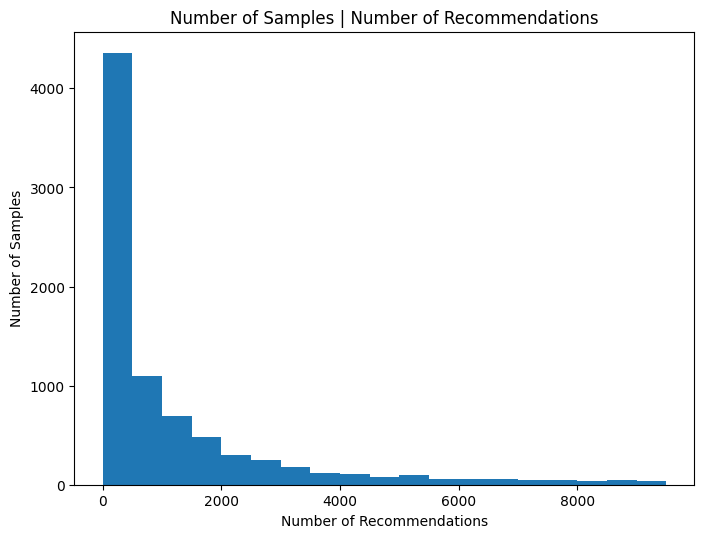

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6], dpi=100)
plt.hist(retDf['Label(Regression)'], bins = np.arange(0,1e4, 500))
plt.title("Number of Samples | Number of Recommendations")
plt.xlabel("Number of Recommendations")
plt.ylabel("Number of Samples")

In [ ]:
retDf.head()

,Required_Age,Controller_support,DLC,Supported_languages,Developers,Platforms,Release_year,Currency(USD),Categories(ID),Genres(ID),...,Dlc_cat,Con_sup,price,Rel_year,Sup_lang,Dev_red,RAM,Processor,Integer_Encoding,Encoding
0,0.0,0.0,0.0,8.0,0,3.0,2000.0,8.86,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,"[0.0, 0.0, 0.0, 8.0, 0, 0, 3.0, 2000.0, 0, 8.8...","[8.86, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,0.0,0.0,0.0,9.0,0,3.0,1999.0,4.99,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,"[0.0, 0.0, 0.0, 9.0, 0, 0, 3.0, 1999.0, 0, 4.9...","[4.99, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,0.0,0.0,0.0,5.0,0,3.0,2003.0,4.99,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,"[0.0, 0.0, 0.0, 5.0, 0, 0, 3.0, 2003.0, 0, 4.9...","[4.99, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,0.0,0.0,0.0,9.0,0,3.0,2001.0,4.99,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,"[0.0, 0.0, 0.0, 9.0, 0, 0, 3.0, 2001.0, 0, 4.9...","[4.99, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,0.0,0.0,0.0,4.0,1,3.0,1999.0,4.99,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,"[0.0, 0.0, 0.0, 4.0, 0, 0, 3.0, 1999.0, 1, 4.9...","[4.99, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


## Make Graph

In [ ]:
from collections import deque

def BFS(A_full, start_node, length=10, tup=False, include_self=False):

    walk = []
    edges = [[start_node, start_node]]
    frontier = deque([start_node])
    if not include_self:
        edges = []

    while len(walk)< length and len(frontier)>0:
        cur_node = frontier.popleft()
        if cur_node in walk:
            continue
        walk.append(cur_node)

        neighbors = np.where(A_full[cur_node]==1)[0]
        for neigh in neighbors:
            frontier.append(neigh)
            edges.append([cur_node, neigh])

    if tup:
        return walk, edges
    return walk



In [ ]:
def RandomWalk(A_full, start_node, p, q, length=10, tup=False, include_self=False):

    walk = [start_node]
    edges = [[start_node, start_node]]
    if not include_self:
        edges = []
    cur_node = start_node
    prev_node = None

    neighbors = np.where(A_full[cur_node]==1)[0]
    probs = np.array([1/q]*len(neighbors))
    probs = probs/probs.sum()
    prev_node = cur_node
    cur_node = np.random.choice(neighbors, p=probs)
    walk.append(cur_node)
    edges.append([prev_node, cur_node])

    while len(walk)<length:
        neighbors = np.where(A_full[cur_node]==1)[0]
        probs = []
        for neigh in neighbors:
            if neigh==prev_node:
                probs.append(1/p)
            # elif A_full[prev_node][neigh] == 1:
            #     probs.append(1)
            else:
                probs.append(1/q)

        # probs = np.array([1/q if neigh!=prev_node else 1/p for neigh in neighbors])
        probs = np.array(probs)
        probs = probs/probs.sum()
        new_node = np.random.choice(neighbors, p=probs)

        if new_node in walk and np.random.rand()>0.01:
            prev_node, cur_node = prev_node, new_node
            continue

        if new_node == start_node:
            continue

        prev_node, cur_node = cur_node, new_node
        walk.append(cur_node)
        edges.append([prev_node, cur_node])
    if tup:
        return walk, edges
    return walk


### IOU on 1

Find the IoU matrix, which will later be used for edge reduction to avoid oversmoothing.

$A=UU^T$

$IoU=A/(N+N^T-A)$

In [ ]:
cat = [np.array(list(retDf['Categories(ID)'].values)),np.array(list(retDf['Genres(ID)'].values)), np.array(list(retDf['Release_years']))]

cat = np.hstack(cat)
print('cat shape ==',cat.shape)
edge_cat = cat @ cat.T

print('edge_cat shape ==',edge_cat.shape)
norm = cat.sum(axis=-1)
norm = norm.reshape(-1,1).repeat(len(norm), axis=-1)
print(norm)
print(f'norm shape == {norm.shape}')
cross_norm = norm + norm.T
IOU = (edge_cat)/ (cross_norm-edge_cat)
IOU = IOU - np.eye(len(IOU))
print(f'IOU shape == {norm.shape}')

-290 edges out of 485809 possible edges (-0.12%)
IOU around the 590th data


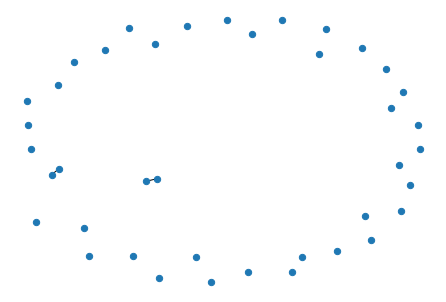

In [ ]:
TH = 0.9
adj_mat = (IOU > TH).astype(np.int32)

all_count = int((np.sum(IOU > 0) - len(IOU))/2)
edge_count = int((np.sum(IOU > TH) - len(IOU))/2)
print(f"{edge_count} edges out of {len(IOU)**2} possible edges ({edge_count/all_count*100:.2f}%)")
location = 590
sq_radius = 20
print(f"IOU around the {location}th data")
sample_edge = adj_mat[location-sq_radius:location+sq_radius,location-sq_radius:location+sq_radius]
# print(np.vectorize(lambda x: round(x, 1))(IOU[location-sq_radius:location+sq_radius,location-sq_radius:location+sq_radius]))
G = nx.from_numpy_matrix(sample_edge)
nx.draw_spring(G, node_size = 40, )

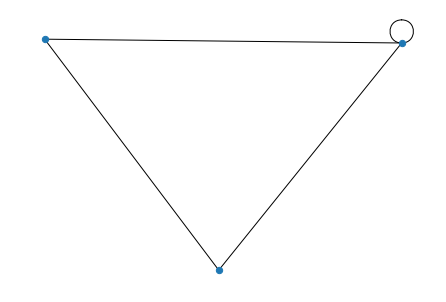

In [ ]:
connected = adj_mat.sum(axis=1) > 0
adj_mat = adj_mat[connected, :][:, connected]
tup_tot = []
node = 0
p, q = 2, 8
length = 3
neighbors = np.where(adj_mat[node]==1)[0]
num_walks = 4

# Nodes, tup = RandomWalk(adj_mat, node, p, q, length=length, tup=True, include_self=True)
# tup_tot += tup

# for neigh in neighbors:
#     for j in range(num_walks):
#         Nodes, tup = RandomWalk(adj_mat, neigh, p, q, length=length,tup=True, include_self=False)
#         tup_tot += tup
nodes, tup_tot = BFS(adj_mat, node,  tup=True, include_self=True)


G = nx.from_edgelist(tup_tot)
nx.draw_spring(G, node_size = 40, )
plt.show()

In [ ]:
np.where(adj_mat[101]==1)[0]

array([  28,  112,  119,  590,  627,  649,  757,  779,  800, 2514, 2585,
       3539, 4974, 5071, 5396, 6214, 6573])

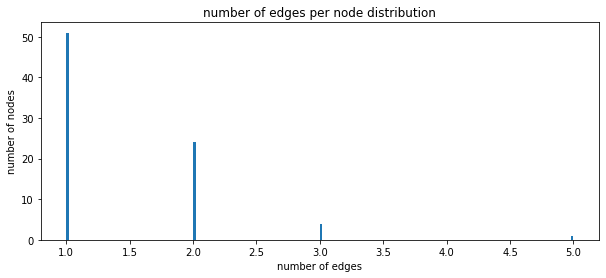

In [ ]:
degs = adj_mat.sum(axis=1)
plt.figure(figsize=[10,4])
plt.title('number of edges per node distribution')
plt.xlabel('number of edges')
plt.ylabel('number of nodes')
plt.hist(degs, bins=200)
plt.show()

### IOU on 1, 0

In [ ]:
retDf['price'] = retDf['Currency(USD)']
enc_len = int(retDf['price'].max()-retDf['price'].min())
enc_min = retDf['price'].min()

def judge(x):
    digit = int(x - enc_min)

    l = list([1]*(digit//10)+[0]*(enc_len//10-digit//10))

    return l

retDf['price'] = retDf['price'].apply(judge)
np.array(list(retDf['price'])).shape

(8903, 9)

In [ ]:
cat = [np.array(list(retDf['Categories(ID)'].values)),np.array(list(retDf['Genres(ID)'].values)),
       np.array(list(retDf['Rel_year'].values)), np.array(list(retDf['Dev_red'].values)), np.array(list(retDf['Sup_lang'].values)),
       np.array(list(retDf['price'].values)), np.array(list(retDf['Dlc_cat'].values)),  np.array(list(retDf['Con_sup'].values)),
       np.array(list(retDf['Plat'].values)), np.array(list(retDf['Req_Age'].values))]

# cat = [np.array(list(retDf['price'].values))]


# cat = [np.array(list(retDf['Categories(ID)'].values)),np.array(list(retDf['Genres(ID)'].values)),
#        np.array(list(retDf['Rel_year'].values)), np.array(list(retDf['Dev_red'].values)), np.array(list(retDf['Sup_lang'].values)),
#        np.array(list(retDf['price'].values))]


# cat = [np.array(list(retDf['Categories(ID)'].values)),np.array(list(retDf['Genres(ID)'].values)),
#        np.array(list(retDf['Rel_year'])), np.array(list(retDf['Dev_red'])), np.array(list(retDf['Sup_lang']))]

# cat = [np.array(list(retDf['Categories(ID)'].values)),np.array(list(retDf['Genres(ID)'].values)),
#        np.array(list(retDf['Release_years'])), np.array(list(retDf['Dev_red']))]

# cat = [np.array(list(retDf['Categories(ID)'].values)),np.array(list(retDf['Genres(ID)'].values)), np.array(list(retDf['Release_years']))]

# cat = [np.array(list(retDf['Categories(ID)'].values)),np.array(list(retDf['Genres(ID)'].values))]
# cat = [np.array(list(retDf['Categories(ID)'].values))]
# cat = [np.array(list(retDf['Genres(ID)'].values))]

cat = np.hstack(cat)
cat = cat
ncat = -1 * (cat - np.ones_like(cat))


print('cat shape ==',cat.shape)
edge_cat = cat @ cat.T
edge_ncat = ncat @ ncat.T

cat shape == (8903, 264)


In [ ]:
edge_tot = edge_cat + edge_ncat
edge_tot = edge_tot - np.eye(len(edge_tot))* np.diag(edge_tot)
edge_filt = (edge_tot - (cat.shape[1]-10) >=0).astype(np.int32)
edge_filt[:10,:10]

array([[0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
       [1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

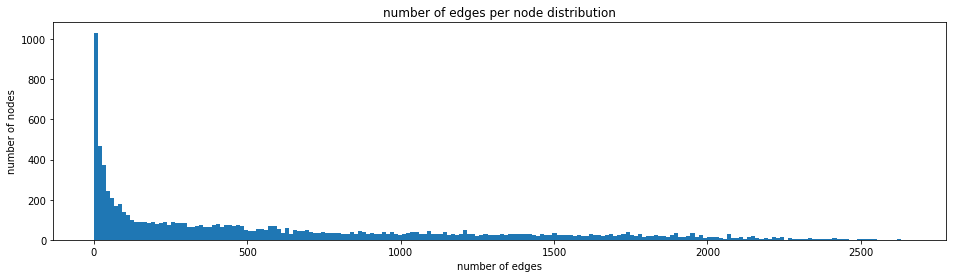

In [ ]:
degs = edge_filt.sum(axis=1)
plt.figure(figsize=[16,4])
plt.title('number of edges per node distribution')
plt.xlabel('number of edges')
plt.ylabel('number of nodes')
plt.hist(degs, bins=200)
plt.show()

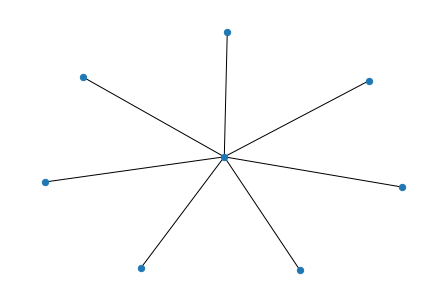

In [ ]:
connected = edge_filt.sum(axis=1) > 0
adj_mat = edge_filt[connected, :][:, connected]
Nodes, tup = RandomWalk(adj_mat, 100, 2, 8000, length=8,tup=True)
G = nx.from_edgelist(tup)
nx.draw_spring(G, node_size = 40, )
plt.show()

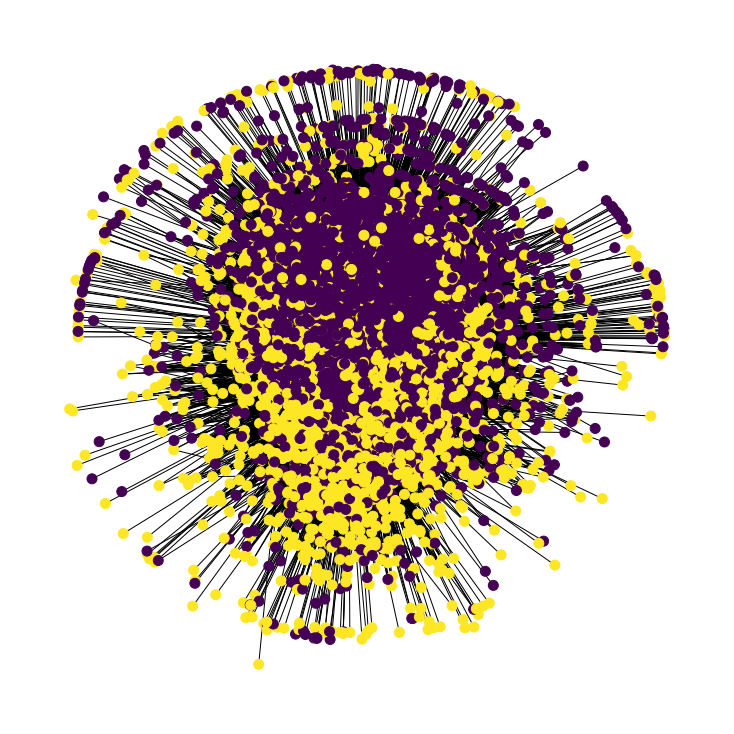

In [ ]:
connected = edge_filt.sum(axis=1) > 0
adj_mat = edge_filt[connected, :][:, connected]
tup_tot = []
node = 1002
p, q = 2, 8
length = 3
neighbors = np.where(adj_mat[node]==1)[0]
num_walks = 4

# Nodes, tup = RandomWalk(adj_mat, node, p, q, length=length, tup=True, include_self=True)
# tup_tot += tup

# for neigh in neighbors:
#     for j in range(num_walks):
#         Nodes, tup = RandomWalk(adj_mat, neigh, p, q, length=length,tup=True, include_self=False)
#         tup_tot += tup
nodes, tup_tot = BFS(adj_mat, node, length=200,tup=True, include_self=True)
idxes = sorted(list(set(np.array(tup_tot).reshape(-1))))


labels = retDf['Label(Binary Classification)'].values[idxes]
G = nx.from_edgelist(tup_tot)

val_map = {i:f for i,f in zip(idxes, labels)}
values = [val_map[node] for node in G.nodes()]

plt.figure(figsize=(10,10))

nx.draw_spring(G, cmap=plt.get_cmap('viridis'), node_size = 100, node_color=values, with_labels=False)
plt.show()

5345094 edges out of 79263409 possible edges (6.74%)


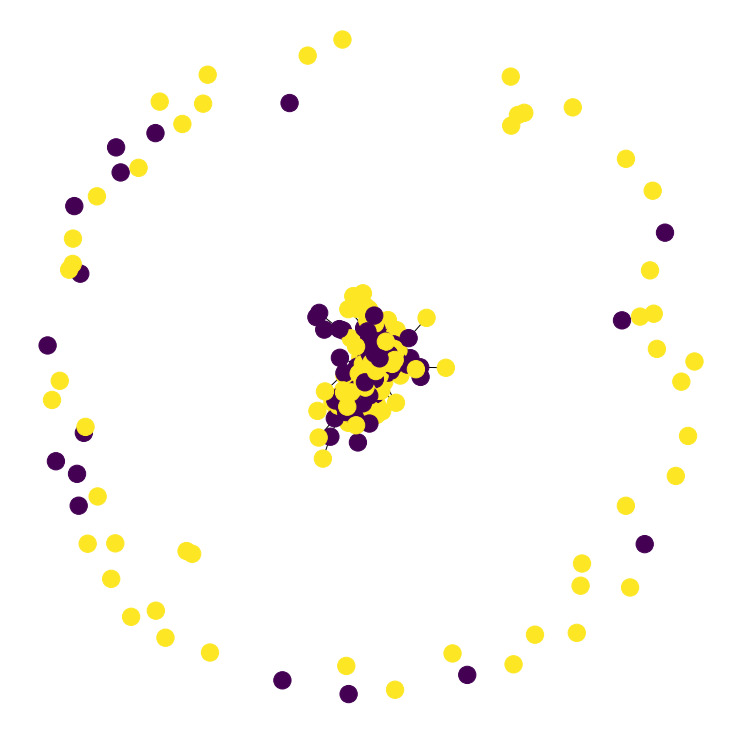

In [ ]:
connected = edge_filt.sum(axis=1) > 0
adj_mat = edge_filt

all_count = np.sum(adj_mat >= 0)
edge_count = np.sum(adj_mat == 1)
print(f"{edge_count} edges out of {len(adj_mat)**2} possible edges ({edge_count/all_count*100:.2f}%)")

idxes = np.random.permutation(len(adj_mat))[:300]
sample_edge = adj_mat[idxes,:][:,idxes]
labels = retDf['Label(Binary Classification)'].values[idxes]
G =  nx.from_numpy_matrix(sample_edge)
val_map = {i:f for i,f in enumerate(labels)}
values = [val_map[node] for node in G.nodes()]

plt.figure(figsize=(10,10))
nx.draw_spring(G, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=False)
plt.show()

### IOU on 1, 0 Multiplex

In [ ]:
retDf['price'] = retDf['Currency(USD)']
enc_len = int(retDf['price'].max()-retDf['price'].min())
enc_min = retDf['price'].min()

def judge(x):
    digit = int(x - enc_min)

    l = list([1]*(digit)+[0]*(enc_len-digit))

    return l

retDf['price'] = retDf['price'].apply(judge)
np.array(list(retDf['price'])).shape

(8903, 99)

In [ ]:
multi_graphs = []
target_arrays = [[np.array(list(retDf['Categories(ID)'].values))],
                [np.array(list(retDf['Genres(ID)'].values))],
                [np.array(list(retDf['Sup_lang'].values))],
                [np.array(list(retDf['price'].values))],
                [np.array(list(retDf['Rel_year'].values))],]

for arrays in tqdm(target_arrays):
    cat = np.hstack(arrays)
    ncat = -1 * (cat - np.ones_like(cat))
    print('cat shape ==',cat.shape)
    edge_cat = cat @ cat.T
    edge_ncat = ncat @ ncat.T
    edge_tot = edge_cat + edge_ncat
    multi_graphs.append(edge_tot)



  0%|          | 0/5 [00:00<?, ?it/s]

cat shape == (8903, 51)
cat shape == (8903, 80)
cat shape == (8903, 29)
cat shape == (8903, 99)
cat shape == (8903, 25)


In [ ]:
cat_shapes = [np.hstack(arr).shape[1] for arr in target_arrays ]

(8903, 8903)
[[0 1 0 1 0 1 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


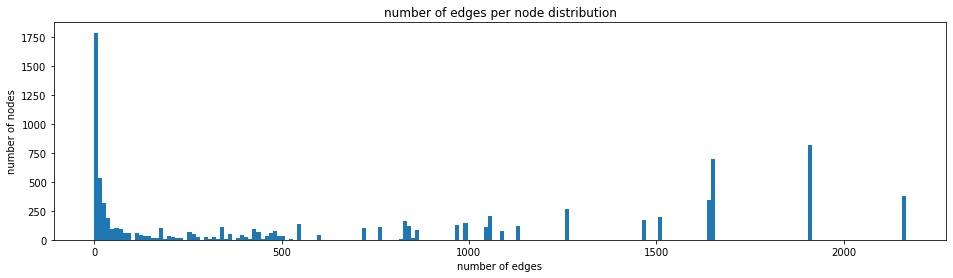

(8903, 8903)
[[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


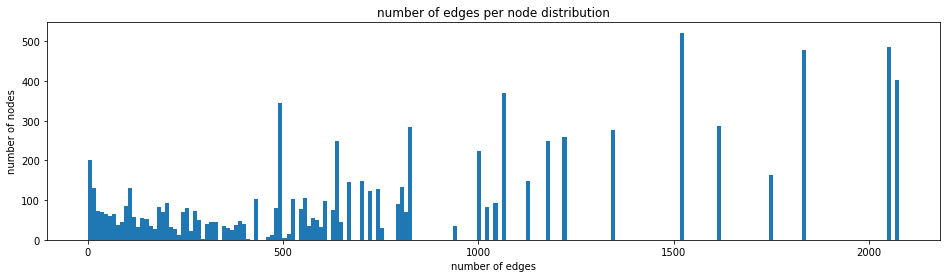

(8903, 8903)
[[0 1 0 1 0 1 1 1 0 0]
 [1 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 1 0 0 0 1 1 1 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [1 1 0 1 0 0 1 1 0 0]
 [1 1 0 1 0 1 0 1 0 0]
 [1 1 0 1 0 1 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


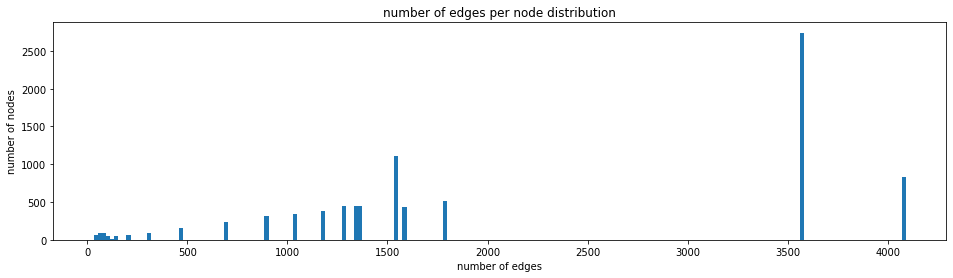

(8903, 8903)
[[0 0 0 0 0 0 1 1 0 1]
 [0 0 1 1 1 1 0 0 1 0]
 [0 1 0 1 1 1 0 0 1 0]
 [0 1 1 0 1 1 0 0 1 0]
 [0 1 1 1 0 1 0 0 1 0]
 [0 1 1 1 1 0 0 0 1 0]
 [1 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 1 0 0 1]
 [0 1 1 1 1 1 0 0 0 0]
 [1 0 0 0 0 0 1 1 0 0]]


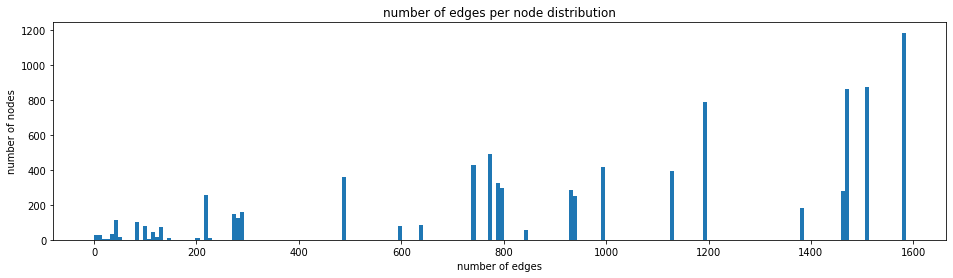

(8903, 8903)
[[0 1 0 1 1 1 0 0 1 0]
 [1 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 1 0 0 1 0]
 [1 1 0 0 0 1 1 0 0 0]
 [1 1 0 1 1 0 0 0 1 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]]


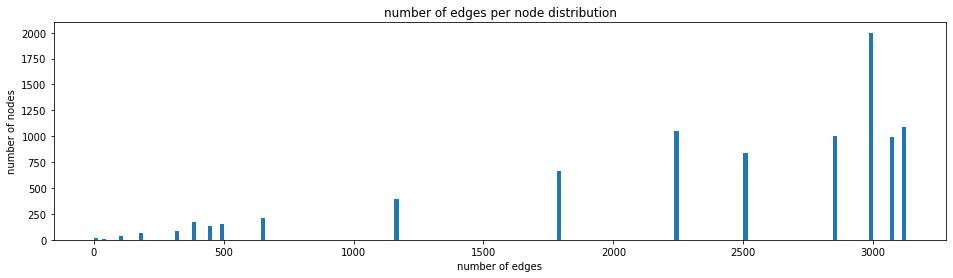

In [ ]:
multi_graphs_th = []
[1, 1, 1]
for g_idx in range(len(multi_graphs)):
    edge_tot = multi_graphs[g_idx][::]
    print(edge_tot.shape)

    edge_tot = edge_tot - np.eye(len(edge_tot))* np.diag(edge_tot)
    edge_filt = (edge_tot - (cat_shapes[g_idx]-1) >=0).astype(np.int32)
    print(edge_filt[:10,:10])
    degs = edge_filt.sum(axis=1)
    plt.figure(figsize=[16,4])
    plt.title('number of edges per node distribution')
    plt.xlabel('number of edges')
    plt.ylabel('number of nodes')
    plt.hist(degs, bins=200)
    plt.show()
    multi_graphs_th.append(edge_filt)

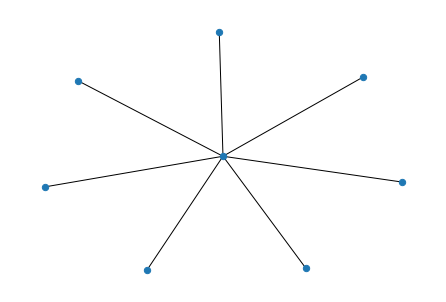

In [ ]:
connected = edge_filt.sum(axis=1) > 0
adj_mat = edge_filt[connected, :][:, connected]
Nodes, tup = RandomWalk(adj_mat, 100, 2, 8000, length=8,tup=True)
G = nx.from_edgelist(tup)
nx.draw_spring(G, node_size = 40, )
plt.show()

In [ ]:
seed_everything(1222)

tup_tot = []
node = 1002
p, q = 2, 8
length = 3
num_walks = 4
for g_idx in range(len(multi_graphs_th)):

    edge_filt = multi_graphs_th[g_idx]
    connected = edge_filt.sum(axis=1) > 0
    adj_mat = edge_filt[connected, :][:, connected]

    neighbors = np.where(adj_mat[node]==1)[0]

    # Nodes, tup = RandomWalk(adj_mat, node, p, q, length=length, tup=True, include_self=True)
    # tup_tot += tup

    # for neigh in neighbors:
    #     for j in range(num_walks):
    #         Nodes, tup = RandomWalk(adj_mat, neigh, p, q, length=length,tup=True, include_self=False)
    #         tup_tot += tup
    nodes, tup_tot = BFS(adj_mat, node, length=10,tup=True, include_self=True)
    idxes = sorted(list(set(np.array(tup_tot).reshape(-1))))

    labels = retDf['Label(Binary Classification)'].values[idxes]
    G = nx.from_edgelist(tup_tot)
    val_map = {i:f for i,f in zip(idxes, labels)}
    values = [val_map[node] for node in G.nodes()]

    nodes = list(set(np.array(tup_tot).reshape(-1)))
    sample_edge = adj_mat[nodes,:][:,nodes]

    labels = retDf['Label(Binary Classification)'].values[nodes]
    G =  nx.from_numpy_matrix(sample_edge)
    val_map = {i:f for i,f in enumerate(labels)}
    values = [val_map[node] for node in G.nodes()]

    plt.figure(figsize=(8,8))
    nx.draw_spring(G, cmap=plt.get_cmap('viridis'), node_size = 40, node_color=values, with_labels=False)
    plt.show()

6813404 edges out of 79263409 possible edges (8.60%)


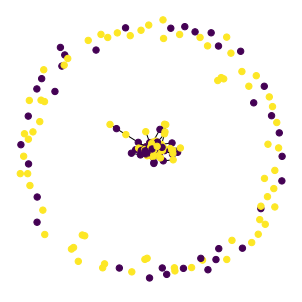

8291210 edges out of 79263409 possible edges (10.46%)


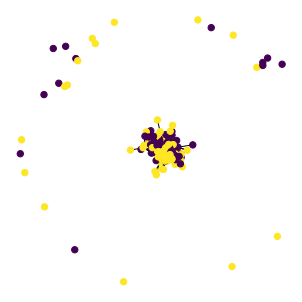

19707248 edges out of 79263409 possible edges (24.86%)


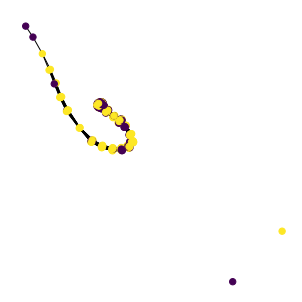

8990914 edges out of 79263409 possible edges (11.34%)


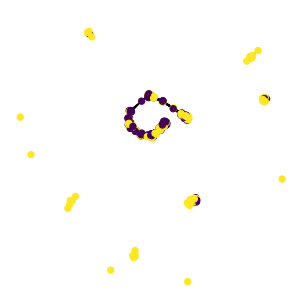

21775128 edges out of 79263409 possible edges (27.47%)


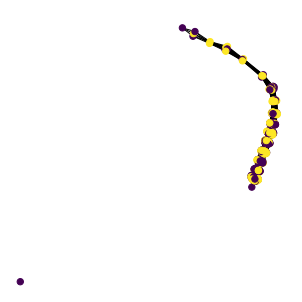

In [ ]:
seed_everything(1222)
idxes = np.random.permutation(len(adj_mat))[:300]

for g_idx in range(len(multi_graphs_th)):
    edge_filt = multi_graphs_th[g_idx]
    connected = edge_filt.sum(axis=1) > 0
    adj_mat = edge_filt

    all_count = np.sum(adj_mat >= 0)
    edge_count = np.sum(adj_mat == 1)
    print(f"{edge_count} edges out of {len(adj_mat)**2} possible edges ({edge_count/all_count*100:.2f}%)")
    sample_edge = adj_mat[idxes,:][:,idxes]
    labels = retDf['Label(Binary Classification)'].values[idxes]
    G =  nx.from_numpy_matrix(sample_edge)
    val_map = {i:f for i,f in enumerate(labels)}
    values = [val_map[node] for node in G.nodes()]

    plt.figure(figsize=(4,4))
    nx.draw_spring(G, cmap=plt.get_cmap('viridis'), node_size=40, node_color=values, )
    plt.show()

## Train Test Split

### Single Graph

In [ ]:
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

connected = edge_filt.sum(axis=1) == edge_filt.sum(axis=1)
adj_mat = edge_filt[connected, :][:, connected]
cat_reduce = cat[connected]
print(adj_mat.shape)

partial_label = [lab for id, lab in enumerate(retDf['Label(Binary Classification)'].values[connected])]
label_dict = {int(id):int(lab) for id, lab in enumerate(partial_label)}

G = nx.from_numpy_matrix(adj_mat)
nx.set_node_attributes(G, label_dict, name='label')

(8903, 8903)


In [ ]:
seed_everything(1222)
idxes = np.arange(len(adj_mat))
id_map = {i: idx for i, idx in enumerate(idxes)}

In [ ]:
# get the feature vectors (both cat and num) for each node
features =  np.hstack([np.asarray(list(retDf["Currency(USD)"].apply(lambda x: [x]).values[connected])), cat_reduce])
features = torch.Tensor(features[idxes]).type(torch.float32)

# get the labels
labels = torch.Tensor(retDf['Label(Binary Classification)'].values[idxes]).type(torch.int64)

# get the edges
edges = [[id_map[u],id_map[v]] for u,v in G.edges if G.has_edge(v,u)]
edges = torch.Tensor(np.array(edges).T).long()

perm_idx = np.random.permutation(len(labels))
idx_train = perm_idx[:int(len(labels)*0.8)]
idx_test = perm_idx[int(len(labels)*0.8):]

idx_train = torch.LongTensor(idx_train)
idx_test = torch.LongTensor(idx_test)

### Multi Graph

In [ ]:
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

feature_array = []
graph_array = []
for edge_filt, cat_reduce in tqdm(zip(multi_graphs_th, target_arrays)):

    connected = edge_filt.sum(axis=1) == edge_filt.sum(axis=1)
    adj_mat = edge_filt[connected, :][:, connected]
    cat_reduce = np.hstack(cat_reduce)
    print(cat_reduce.shape)

    G = nx.from_numpy_array(adj_mat)
    idxes = np.arange(len(adj_mat))
    id_map = {i: idx for i, idx in enumerate(idxes)}

    # get the feature vectors (both cat and num) for each node
    features = torch.Tensor(cat_reduce).type(torch.float32)
    feature_array.append(features)
    # get the labels

    # get the edges
    edges = [[id_map[u],id_map[v]] for u,v in G.edges if G.has_edge(v,u)]
    edges = torch.Tensor(np.array(edges).T).long()
    graph_array.append(edges)



0it [00:00, ?it/s]

(8903, 51)
(8903, 80)
(8903, 29)
(8903, 99)
(8903, 25)


In [ ]:
partial_label = [lab for id, lab in enumerate(retDf['Label(Binary Classification)'].values)]
label_dict = {int(id):int(lab) for id, lab in enumerate(partial_label)}
labels = torch.Tensor(retDf['Label(Binary Classification)'].values).type(torch.int64)

seed_everything(1222)

perm_idx = np.random.permutation(len(labels))
idx_train = perm_idx[:int(len(labels)*0.8)]
idx_test = perm_idx[int(len(labels)*0.8):]
idx_train = torch.LongTensor(idx_train)
idx_test = torch.LongTensor(idx_test)

features = torch.hstack(feature_array)

In [ ]:
sum(labels[idx_train]==1)/len(labels[idx_train])

tensor(0.5110)

## Random Forest

### Basic Forest

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

seed_everything(1222)
clf = RandomForestClassifier(n_estimators=1024,
                             max_depth=32,
                             max_samples=3240,
                             )
clf.fit(features[idx_train].cpu().numpy(), labels[idx_train].cpu().numpy())
print((clf.predict(features[idx_train].cpu().numpy()) == labels[idx_train].cpu().numpy()).sum() / len(idx_train))
print((clf.predict(features[idx_test].cpu().numpy()) == labels[idx_test].cpu().numpy()).sum() / len(idx_test))

0.9671440606571188
0.7439640651319483


### Crazy Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=128,
                             max_depth=128,
                             max_samples=3240,
                             )
ff = np.hstack([features.cpu().numpy(), *[arr for arr in multi_graphs_th] ])

clf.fit(ff[idx_train], labels[idx_train].cpu().numpy())


In [ ]:
print((clf.predict(ff[idx_train]) == labels[idx_train].cpu().numpy()).sum() / len(idx_train))
print((clf.predict(ff[idx_test]) == labels[idx_test].cpu().numpy()).sum() / len(idx_test))

0.9615276607694467
0.7164514317798989


## GCN

### Model Definition

### Baisc GCN

In [ ]:
import torch
import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
class GCN(torch.nn.Module):
    def __init__(self,feature, hidden, embeddings, classes=2):
        super(GCN, self).__init__()
        self.embed = torch.nn.Linear(feature, hidden)
        self.conv1 = GCNConv(hidden, hidden)
        self.conv2 = GCNConv(hidden, embeddings)
        self.fc1 = torch.nn.Linear(embeddings, embeddings//2)
        self.fc2 = torch.nn.Linear(embeddings//2, classes)

    def forward(self, features, edges):
        features = self.embed(features)
        features = self.conv1(features, edges)
        features = F.relu(features)
        features = F.dropout(features, training=self.training)
        features = self.conv2(features, edges)
        x = F.relu(self.fc1(features))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

### One Graph

In [ ]:
import torch
import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
class GCN(torch.nn.Module):
    def __init__(self,n_nodes, n_features, hidden, use_base=False, use_graph=False, classes=2):
        super(GCN, self).__init__()
        self.use_base = use_base
        self.use_graph = use_graph
        self.embed = torch.nn.Sequential(
            torch.nn.Linear(n_features, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),

        )

        self.idxes = torch.nn.Parameter(torch.arange(n_nodes),requires_grad=False)
        self.conv1 = GCNConv(hidden, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, hidden)
        self.conv4 = GCNConv(hidden, hidden)

        if self.use_base:
            cat_length = n_features # baseline
        else:
            cat_length = hidden

        self.fc1 = torch.nn.Linear(cat_length, hidden)
        self.fc2 = torch.nn.Linear(hidden, hidden//2)
        self.fc3 = torch.nn.Linear(hidden//2, classes)
        self.direct_fc = torch.nn.Linear(n_features, hidden)

    def forward(self, features, edges):
        if self.use_base:
            feature_out = features # baseline
        else:
            feature_out = self.graph_forward(features, edges)

        x = F.leaky_relu(self.fc1(feature_out))
        if not self.use_base and not self.use_graph:
            x = torch.add(x, self.direct_fc(features))

        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

    def graph_forward(self, features, edges):
        feature0 = self.embed(features)

        feature1 = self.conv1(feature0, edges)
        feature1 = F.leaky_relu(feature1)

        feature2 = self.conv2(feature1, edges)
        feature2 = F.leaky_relu(feature2)
        feature2 = torch.add(feature1, feature2)

        feature3 = self.conv3(feature2, edges)
        feature3 = F.leaky_relu(feature3)
        feature3 = torch.add(feature2, feature3)

        return feature3

#### New Training Loop

In [ ]:
seed_everything(1222)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features = features.to(device)
model = GCN(features.shape[0],features.shape[1], 512, use_base=False, use_graph=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
model.train()
model = model.to(device)


edges = edges.to(device)
labels = labels.to(device)
bs = 2048

max_acc = 0
max_message = ''
to_plot = []
for epoch in tqdm(range(600)):
    outs = []
    # for it in range(0, len(features), bs):
    train_correct = []
    idxes = torch.randperm(idx_train.shape[0])
    idxes = idx_train[idxes].to(device)
    for iter in range(0, len(idxes), bs):
        optimizer.zero_grad()
        idx = idxes[iter:iter+bs]
        # part_features = features[idx] 512
        part_edges = edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)]
        out = model(features, part_edges)
    # out = model(features, edges)

        outs.append(out)
        loss = F.nll_loss(out[idx], labels[idx])       
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_correct.append(float(sum(out[idx].argmax(-1)==labels[idx])))

    train_acc = int(sum(train_correct))/len(labels[idx_train])


    if epoch%10 == 0:
        outs = torch.stack(outs)
        message = f"epoch:{epoch+1}, loss=={loss.item():.4f}, acc=={train_acc:.4f}"
        print(f"epoch:{epoch+1}, loss=={loss.item():.4f}, acc=={train_acc:.4f}", end = ' ')
        model.eval()
        with torch.no_grad():
            idxes = idx_test.to(device)
            correct = []
            preds = []
            for iter in range(0, len(idxes), bs):
                idx = idxes[iter:iter+bs]
                part_edges = edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)]
                _, pred = model(features, part_edges).max(dim=1)
                # preds.append(pred)
                correct.append(pred[idx].eq(labels[idx]).sum())           

            acc = int(sum(correct)) / int(len(idx_test))                       

        to_plot.append([train_acc, acc])

        if acc> max_acc:
            max_acc = acc
            max_message = message
        print(f"val_acc=={acc:.4f}")
        model.train()
print(max_message, max_acc)

  0%|          | 0/600 [00:00<?, ?it/s]

epoch:1, loss==0.6988, acc==0.5051 val_acc==0.5109
epoch:11, loss==0.4356, acc==0.7713 val_acc==0.7406
epoch:21, loss==0.4663, acc==0.7651 val_acc==0.8080
epoch:31, loss==0.3960, acc==0.8281 val_acc==0.8158
epoch:41, loss==0.4075, acc==0.8126 val_acc==0.7945
epoch:51, loss==0.4265, acc==0.8100 val_acc==0.8125
epoch:61, loss==0.3509, acc==0.8385 val_acc==0.7962
epoch:71, loss==0.3594, acc==0.8419 val_acc==0.7490
epoch:81, loss==0.4597, acc==0.8345 val_acc==0.7793
epoch:91, loss==0.3468, acc==0.8513 val_acc==0.7193
epoch:101, loss==0.3260, acc==0.8593 val_acc==0.7793


KeyboardInterrupt: ignored

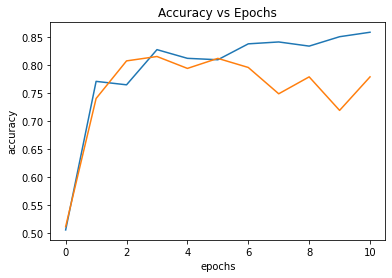

In [ ]:
z = np.array(to_plot).T
x = np.arange(len(z[0]))
plt.title('Accuracy vs Epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(x, z[0])
plt.plot(x, z[1])

In [ ]:
with torch.no_grad():
        idxes = idx_test.to(device)
        correct = []
        preds = []
        for iter in range(0, len(idx_train), bs):
            idx = idxes[iter:iter+bs]
            part_edges = edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)]
            _, pred = model(features, part_edges).max(dim=1)
            # preds.append(pred)
            correct.append(pred[idx].eq(labels[idx]).sum())      

        acc = int(sum(correct)) / int(len(idx_test))
acc

0.8596294216732173

#### Old Training Loop

In [ ]:
seed_everything(1022)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model = GCN(features.shape[0],features.shape[1], 512, use_base=False, use_graph=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
model.train()
model = model.to(device)

features = features.to(device)
edges = edges.to(device)
labels = labels.to(device)
bs = 2048

max_acc = 0
max_message = ''
for epoch in tqdm(range(600)):
    # outs = []
    # for it in range(0, len(features), bs):
    idxes = torch.randperm(idx_train.shape[0])
    idxes = idx_train[idxes].to(device)
    for iter in range(0, len(idx_train), bs):
        optimizer.zero_grad()
        idx = idxes[iter:iter+bs]
        # part_features = features[idx] 512
        part_edges = edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)]
        out = model(features, part_edges)
    # out = model(features, edges)

        # outs.append(out)
        loss = F.nll_loss(out[idx], labels[idx])       
        loss.backward()
        optimizer.step()

    if epoch%10 == 0:
        # outs = torch.stack(outs)
        acc = float(sum(out[idx_train].argmax(-1)==labels[idx_train])/len(labels[idx_train]))
        message = f"epoch:{epoch+1}, loss=={loss.item():.4f}, acc=={acc:.4f}"
        print(f"epoch:{epoch+1}, loss=={loss.item():.4f}, acc=={acc:.4f}", end = ' ')
        # model.eval()
        with torch.no_grad():
            test_idxes = idx_test.to(device)
            correct = []
            # preds = []
            for iter in range(0, len(idx_test), bs):
                idx = test_idxes[iter:iter+bs]
                part_edges = edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)]
                _, pred = model(features, part_edges).max(dim=1)
                correct.append((pred[idx]==labels[idx]).sum())         

            acc = int(sum(correct)) / int(len(idx_test))                     

        if acc> max_acc:
            max_acc = acc
            max_message = message
        print(f"val_acc=={acc:.4f}")

print(max_message, max_acc)

  0%|          | 0/600 [00:00<?, ?it/s]

epoch:1, loss==1.6197, acc==0.5090 val_acc==0.5272
epoch:11, loss==0.5891, acc==0.6125 val_acc==0.7007
epoch:21, loss==0.5746, acc==0.6126 val_acc==0.7153
epoch:31, loss==0.5623, acc==0.6136 val_acc==0.6777
epoch:41, loss==0.5360, acc==0.6028 val_acc==0.7153
epoch:51, loss==0.5227, acc==0.6035 val_acc==0.7631
epoch:61, loss==0.5773, acc==0.5959 val_acc==0.7215
epoch:71, loss==0.5354, acc==0.6175 val_acc==0.7558
epoch:81, loss==0.5503, acc==0.6122 

KeyboardInterrupt: ignored

### Multiplex

In [ ]:
import torch
import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
class Multiplex_GCN(torch.nn.Module):
    def __init__(self,n_nodes, n_features_list, n_graphs, hidden, use_base=False, use_graph=False, classes=2):
        super(Multiplex_GCN, self).__init__()
        self.use_base = use_base
        self.use_graph = use_graph


        # self.embed = torch.nn.Embedding(n_nodes, hidden)
        self.idxes = torch.nn.Parameter(torch.arange(n_nodes),requires_grad=False)

        self.gcn_groups = []

        for g, n_feats in zip(range(n_graphs), n_features_list):
            graph_embed = torch.nn.Sequential(
            torch.nn.Linear(n_feats, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
            )
            graph_net = torch.nn.ModuleList(
                [graph_embed,
                 GCNConv(hidden, hidden),
                 GCNConv(hidden, hidden),
                 GCNConv(hidden, hidden),
                 ])
            self.gcn_groups.append(graph_net)

        self.gcn_groups =  torch.nn.ModuleList(self.gcn_groups)

        if self.use_base:
            cat_length = sum(n_features_list) # baseline

        else:
            cat_length = hidden


        self.fc1 = torch.nn.Linear(hidden, hidden)
        self.fc2 = torch.nn.Linear(hidden, hidden)
        self.fc3 = torch.nn.Linear(hidden, classes)

        self.direct_fc1 = torch.nn.Linear(cat_length, hidden)


    def forward(self, feature_array, multiplex_edges):

        if self.use_base:
            features = torch.hstack(feature_array) 

        if self.use_graph:
            feature_container = []
            for layer_idx in range (len(multiplex_edges)):
                feature_container.append(self.graph_forward(feature_array[layer_idx], multiplex_edges[layer_idx], layer_idx))


            feature_out = 0
            for tens in feature_container:
                feature_out = torch.add(feature_out, tens)

        if self.use_base and self.use_graph:
            x = F.leaky_relu(self.fc1(feature_out))
            x = torch.add(x, self.direct_fc1(features))
        elif self.use_graph:
            x = F.leaky_relu(self.fc1(feature_out))
        else:
            x = F.leaky_relu(self.direct_fc1(features))

        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def graph_forward(self, features, edges, layer_idx):

        feature0 = self.gcn_groups[layer_idx][0](features)

        feature1 = self.gcn_groups[layer_idx][1](feature0, edges)
        feature1 = F.leaky_relu(feature1)

        feature2 = self.gcn_groups[layer_idx][2](feature1, edges)
        feature2 = F.leaky_relu(feature2)
        # feature2 = torch.add(feature1, feature2)

        feature3 = self.gcn_groups[layer_idx][3](feature2, edges)
        feature3 = F.leaky_relu(feature3)
        # feature3 = torch.add(feature3, feature2)

        return feature3

#### Training Loop

In [ ]:
[feature_array[i].shape[1] for i in range(len(feature_array))]

[51, 29, 99]

In [ ]:
seed_everything(1022)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
# model = GCN(features.shape[0],features.shape[1], 512, use_base=False, use_graph=True)
model = Multiplex_GCN(feature_array[0].shape[0], [feature_array[i].shape[1] for i in range(len(feature_array))],
                       len(graph_array), 256, use_base=False, use_graph=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
model.train()
model = model.to(device)

feature_array =  [feature_array[i].to(device) for i in range(len(feature_array))]
graph_array = [graph_array[i].to(device) for i in range(len(graph_array))]
labels = labels.to(device)

In [ ]:
seed_everything(1222)

bs = 2500
test_bs = 2000
max_acc = 0
max_message = ''

for epoch in tqdm(range(600)):
    outs = []
    # for it in range(0, len(features), bs):
    idxes = torch.randperm(idx_train.shape[0])
    idxes = idx_train[idxes].to(device)
    train_correct = []

    for iter in range(0, len(idxes), bs):
        optimizer.zero_grad()
        idx = idxes[iter:iter+bs]
        part_edges = []
        for edges in graph_array:
            part_edges.append(edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)])

        part_features = []
        for feats in feature_array:
            cond = torch.zeros_like(feats).to(device)
            cond[idx, :] = 1
            cond = cond.type(torch.bool)
            part_features.append(torch.where(cond, feats, feats*0))

        out = model(part_features, part_edges)
        # out = model(feature_array, part_edges)

        outs.append(out)
        loss = F.nll_loss(out[idx], labels[idx]) 
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_correct.append((out[idx].argmax(-1)==labels[idx]).sum())

    train_acc = int(sum(train_correct)) / int(len(idx_train))

    if epoch%10 == 0:
        outs = torch.stack(outs)
        # train_acc = float(sum(out[idx_train].argmax(-1)==labels[idx_train])/len(labels[idx_train]))
        message = f"epoch:{epoch+1}, loss=={loss.item():.4f}, acc=={train_acc:.4f}"
        print(f"epoch:{epoch+1}, loss=={loss.item():.4f}, acc=={train_acc:.4f}", end=' ')
        model.eval()
        with torch.no_grad():
            idxes = idx_test.to(device)
            test_correct = []
            for iter in range(0, len(idxes), test_bs):
                idx = idxes[iter:iter+test_bs]
                # part_edges = edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)]
                part_edges = []
                for edges in graph_array:
                    part_edges.append(edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)])

                part_features = []
                for feats in feature_array:
                    cond = torch.zeros_like(feats).to(device)
                    cond[idx, :] = 1
                    cond = cond.type(torch.bool)
                    part_features.append(torch.where(cond, feats, feats*0))
                _, pred = model(part_features, part_edges).max(dim=1)

                test_correct.append(pred[idx].eq(labels[idx]).sum())           

            acc = int(sum(test_correct)) / int(len(idx_test))                       

            if acc> max_acc:
                max_acc = acc
                max_message = message
            print(f"val_acc=={acc:.4f}")

        model.train()
print(max_message, max_acc)

  0%|          | 0/600 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
sampleData

,index,type,name,steam_appid,required_age,is_free,controller_support,dlc,detailed_description,about_the_game,...,categories,genres,screenshots,movies,recommendations,achievements,release_date,support_info,background,content_descriptors
0,0,game,Counter-Strike,10,0.0,False,NaN,NaN,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,...,"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 119298},NaN,"{'coming_soon': False, 'date': '1 Nov, 2000'}","{'url': 'http://steamcommunity.com/app/10', 'e...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [2, 5], 'notes': 'Includes intense vio..."
1,1,game,Team Fortress Classic,20,0.0,False,NaN,NaN,One of the most popular online action games of...,One of the most popular online action games of...,...,"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 4525},NaN,"{'coming_soon': False, 'date': 'Apr 1, 1999'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [2, 5], 'notes': 'Includes intense vio..."
2,2,game,Day of Defeat,30,0.0,False,NaN,NaN,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,...,"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 3151},NaN,"{'coming_soon': False, 'date': 'May 1, 2003'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
3,3,game,Deathmatch Classic,40,0.0,False,NaN,NaN,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,...,"[{'id': 1, 'description': 'Multi-player'}, {'i...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 1509},NaN,"{'coming_soon': False, 'date': 'Jun 1, 2001'}","{'url': '', 'email': ''}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
4,4,game,Half-Life: Opposing Force,50,0.0,False,NaN,NaN,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '1', 'description': 'Action'}]","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...",NaN,{'total': 11542},NaN,"{'coming_soon': False, 'date': 'Nov 1, 1999'}","{'url': 'https://help.steampowered.com', 'emai...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [], 'notes': None}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51995,995,game,瓔珞事件簿之誰殺了愛情,1865680,0,False,NaN,NaN,"<img src=""https://cdn.akamai.steamstatic.com/s...","<img src=""https://cdn.akamai.steamstatic.com/s...",...,"[{'id': 2, 'description': 'Single-player'}, {'...","[{'id': '25', 'description': 'Adventure'}, {'i...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256867513, 'name': '誰殺了愛情宣傳PV_簡體', 'th...",NaN,"{'total': 10, 'highlighted': [{'name': '見習偵探',...","{'coming_soon': False, 'date': '30 Jan, 2022'}","{'url': 'www,genuine-studio.com', 'email': 'in...",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [1, 5], 'notes': 'The game contains a ..."
51996,996,game,Cyberpunk Girls,1867280,0,False,NaN,NaN,<strong>Cyberpunk Girls</strong> is a brutal a...,<strong>Cyberpunk Girls</strong> is a brutal a...,...,"[{'id': 2, 'description': 'Single-player'}]","[{'id': '1', 'description': 'Action'}, {'id': ...","[{'id': 0, 'path_thumbnail': 'https://cdn.akam...","[{'id': 256867700, 'name': 'Cyberpunk Girls', ...",NaN,NaN,"{'coming_soon': False, 'date': '5 Feb, 2022'}","{'url': '', 'email': 'forestgames2015@gmail.com'}",https://cdn.akamai.steamstatic.com/steam/apps/...,"{'ids': [1, 2, 5], 'notes': 'The game contains..

In [ ]:
retDf.loc[retDf['Label(Regression)'] > 100000].head()

,Required_Age,Controller_support,DLC,Supported_languages,Developers,Platforms,Release_year,Currency(USD),Categories(ID),Genres(ID),...,Dlc_cat,Con_sup,price,Rel_year,Sup_lang,Dev_red,RAM,Processor,Integer_Encoding,Encoding
0,0.0,0.0,0.0,8.0,0,3.0,2000.0,9.09,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[0],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,"[0.0, 0.0, 0.0, 8.0, 0, 0, 3.0, 2000.0, 0, 9.0...","[9.09, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
9,0.0,0.0,1.0,18.0,0,3.0,2004.0,9.09,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[0],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,"[0.0, 0.0, 1.0, 18.0, 1, 1, 3.0, 2004.0, 0, 9....","[9.09, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
20,0.0,1.0,1.0,28.0,0,3.0,2009.0,9.09,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[1],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,3,"[0.0, 1.0, 1.0, 28.0, 3, 1, 3.0, 2009.0, 0, 9....","[9.09, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ..."
22,0.0,1.0,1.0,22.0,0,3.0,2011.0,9.09,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[1],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,3,"[0.0, 1.0, 1.0, 22.0, 3, 1, 3.0, 2011.0, 0, 9....","[9.09, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
24,0.0,1.0,1.0,28.0,2,3.0,2012.0,0.00,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0]",[1],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,4,"[0.0, 1.0, 1.0, 28.0, 4, 1, 3.0, 2012.0, 2, 0....","[0.0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0..."


In [ ]:
seed_everything(2022)
# idxes = np.random.permutation(len(adj_mat))[:10]
tup_tot = []
node = 0
p, q = 2, 8
length = 3
num_walks = 4
part_edges = []
part_features = []

device = 'cpu'

feature_array =  [feature_array[i].to(device) for i in range(len(feature_array))]
graph_array = [graph_array[i].to(device) for i in range(len(graph_array))]
labels = labels.to(device)
model.to(device)

for g_idx in range(len(multi_graphs_th)):

    edge_filt = multi_graphs_th[g_idx]
    connected = edge_filt.sum(axis=1) > 0
    adj_mat = edge_filt[connected, :][:, connected]

    neighbors = np.where(adj_mat[node]==1)[0]

    # nodes, tup_tot = BFS(adj_mat, node, length=1,tup=True, include_self=True)
    # idx = torch.LongTensor(sorted(list(set(np.array(tup_tot).reshape(-1))))).to(device)
    idx = torch.LongTensor( neighbors).to(device)

    edges = graph_array[g_idx]
    part_edges.append(edges[...,torch.isin(edges[0, :], idx) & torch.isin(edges[1, :], idx)])

    feats = feature_array[g_idx]
    cond = torch.zeros_like(feats).to(device)
    cond[idx, :] = 1
    cond = cond.type(torch.bool)
    part_features.append(torch.where(cond, feats, feats*0))

with torch.no_grad():
    pred = model(part_features, part_edges)

pred.argmin(-1)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
pred.shape

torch.Size([8903, 2])

In [ ]:
pred.argmax(-1)

tensor([1, 1, 1,  ..., 1, 1, 1])

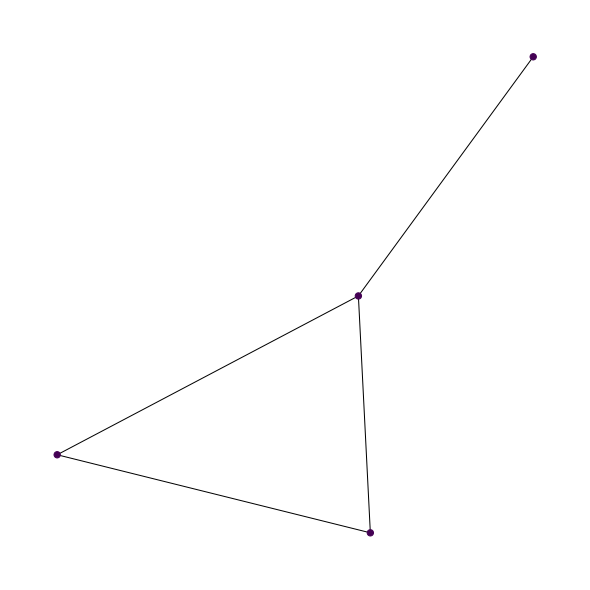

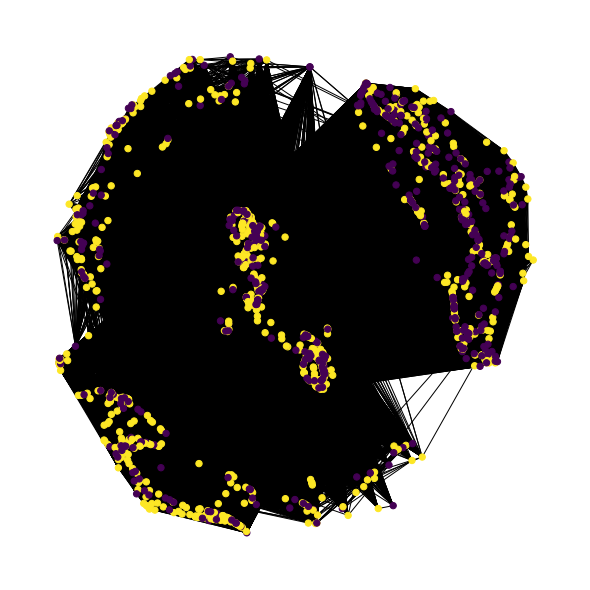

KeyboardInterrupt: ignored

In [ ]:
seed_everything(1222)

tup_tot = []
node = 0
p, q = 2, 8
length = 3
num_walks = 4
for g_idx in range(len(multi_graphs_th)):

    edge_filt = multi_graphs_th[g_idx]
    connected = edge_filt.sum(axis=1) > 0
    adj_mat = edge_filt[connected, :][:, connected]

    neighbors = np.where(adj_mat[node]==1)[0]

    nodes, tup_tot = BFS(adj_mat, node, length=10,tup=True, include_self=True)
    idxes = sorted(list(set(np.array(tup_tot).reshape(-1))))


    # labels = retDf['Label(Binary Classification)'].values[idxes]
    # G = nx.from_edgelist(tup_tot)

    # val_map = {i:f for i,f in zip(idxes, labels)}
    # values = [val_map[node] for node in G.nodes()]

    # # plt.figure(figsize=(4,4))

    # # nx.draw_spring(G, cmap=plt.get_cmap('viridis'), node_size = 40, node_color=values, with_labels=False)
    # # plt.show()


    # nodes = list(set(np.array(tup_tot).reshape(-1)))
    # sample_edge = adj_mat[nodes,:][:,nodes]
    # # print(np.vectorize(lambda x: round(x, 1))(IOU[location-sq_radius:location+sq_radius,location-sq_radius:location+sq_radius]))

    # # G = nx.from_numpy_matrix(sample_edge)
    # # nx.draw_spring(G, node_size = 40, )


    # labels = retDf['Label(Binary Classification)'].values[nodes]
    # G =  nx.from_numpy_matrix(sample_edge)
    # val_map = {i:f for i,f in enumerate(labels)}

    # values = [val_map[node] for node in G.nodes()]

    # plt.figure(figsize=(8,8))

    # nx.draw_spring(G, cmap=plt.get_cmap('viridis'), node_size = 40, node_color=values, with_labels=False)
    # plt.show()

28


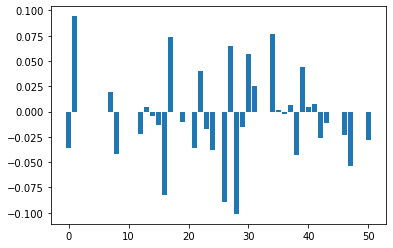

27


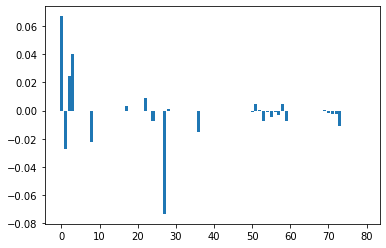

0


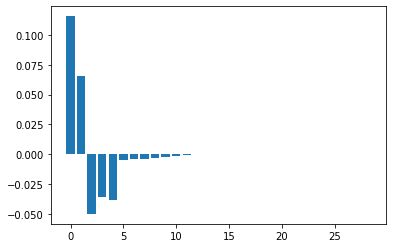

1


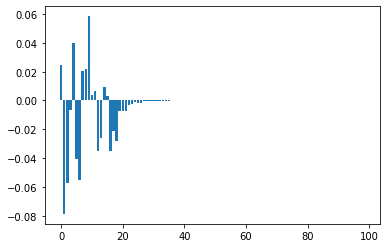

14


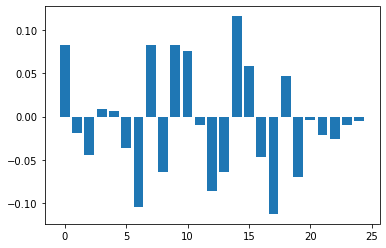

In [ ]:
for i in range(5):
    for j in range(4):
        if j==0:
            w = model.gcn_groups[i][j][0].weight.cpu().detach().numpy()[0]
            print((w**2).argmax(-1))

            plt.bar(np.arange(len(w)), w)
            plt.show()
        else:
            continue
        # else:
            # print(model.gcn_groups[i][j].lin.weight.cpu().detach().numpy())


In [ ]:
model.gcn_groups[i][j]

Sequential(
  (0): Linear(in_features=51, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
(labels[idx_test] == 1)

tensor([False,  True,  True,  ...,  True,  True,  True], device='cuda:0')

In [ ]:
len(labels[idx_test])

1781

In [ ]:
(labels[idx_test] == 1).sum() / len(labels[idx_test])

tensor(0.5109, device='cuda:0')

In [ ]:
len(labels[idx])
idx

tensor([8413, 2683, 1943,  ..., 8209, 5062,   72], device='cuda:0')

In [ ]:
(labels[idx] ==  model(feature_array, part_edges)[idx].argmax(-1)).sum() / len(labels[idx])

tensor(0.7109, device='cuda:0')

In [ ]:
(out[idx].argmax(-1) == labels[idx]).sum()/len(idx)


tensor(0.4826, device='cuda:0')

tensor([0, 0, 0,  ..., 1, 0, 0], device='cuda:0')

In [ ]:
part_edges[0].shape

torch.Size([2, 45217])

In [ ]:
_, pred = model(part_features, part_edges).max(dim=1)

In [ ]:
cond.shape

torch.Size([8903, 99])

In [ ]:
feats.shape

torch.Size([8903, 99])

In [ ]:
labels[idx]

tensor([1, 0, 1,  ..., 1, 0, 0], device='cuda:0')

In [ ]:
(pred[idx] == labels[idx]).sum()/len(idx)

tensor(0.7891, device='cuda:0')

In [ ]:
torch.where(labels[idx] == 1) == torch.where(pred[idx] == 1)

(tensor([   0,    2,    5,    8,   11,   13,   14,   15,   17,   18,   19,   23,
           25,   28,   29,   30,   31,   32,   34,   37,   38,   39,   41,   42,
           47,   50,   51,   53,   55,   57,   58,   59,   60,   61,   64,   68,
           69,   70,   72,   73,   78,   79,   82,   83,   86,   87,   90,   94,
           97,   98,   99,  102,  104,  106,  110,  111,  117,  118,  119,  120,
          124,  125,  126,  127,  131,  132,  133,  134,  135,  136,  138,  140,
          141,  142,  146,  147,  149,  152,  153,  154,  155,  156,  157,  159,
          161,  162,  165,  166,  169,  171,  175,  176,  179,  181,  182,  187,
          188,  189,  190,  192,  193,  194,  195,  197,  198,  199,  201,  203,
          205,  206,  208,  209,  210,  211,  216,  218,  219,  220,  222,  223,
          224,  225,  228,  229,  231,  232,  233,  235,  236,  238,  239,  240,
          243,  244,  245,  246,  247,  248,  250,  251,  254,  255,  256,  258,
          259,  260,  261,  

In [ ]:
torch.where(pred[idx] == 1)

(tensor([   1,    2,    5,    6,    8,   11,   13,   14,   17,   18,   22,   23,
           25,   29,   30,   32,   37,   38,   39,   41,   42,   45,   50,   51,
           53,   55,   57,   58,   59,   61,   64,   68,   70,   73,   77,   78,
           79,   82,   83,   85,   86,   87,   90,   94,   97,   99,  100,  102,
          104,  110,  111,  118,  120,  123,  124,  126,  131,  132,  134,  136,
          140,  141,  144,  146,  147,  149,  152,  153,  154,  155,  156,  162,
          169,  171,  172,  173,  175,  176,  179,  181,  182,  185,  188,  189,
          192,  193,  194,  195,  197,  199,  201,  202,  203,  205,  208,  209,
          211,  212,  216,  220,  223,  224,  229,  232,  233,  235,  238,  239,
          240,  241,  242,  243,  244,  245,  246,  247,  248,  253,  254,  255,
          256,  258,  259,  264,  266,  268,  269,  272,  273,  274,  275,  277,
          278,  282,  283,  284,  288,  290,  292,  293,  294,  295,  298,  299,
          300,  304,  305,  

In [ ]:
labels[idx].sum()

tensor(520, device='cuda:0')

In [ ]:
feats

tensor([[1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
idx_test.shape

torch.Size([1781])

In [ ]:
idx_train.shape

torch.Size([7122])

In [ ]:
model.eval()
_, pred = model(features, edges).max(dim=1)
correct = pred[idx_test].eq(labels[idx_test]).sum()            # 计算预测与标签相等个数
acc = int(correct) / int(len(idx_test))                        # 计算正确率
print(acc)

0.6392199349945829


## Node2Vec

In [ ]:
from tqdm.notebook import tqdm
train_data = []
walks_p_node = 8
walk_length = 8
neg_size = walk_length* 10

p, q = (20, 80)

A_full = adj_mat

degs = A_full.sum(axis = 1) # degress of all nodes
valid_node_idxes = np.where(degs>0)[0]
all_node_idxes = np.arange(len(A_full))

for node_idx in tqdm(valid_node_idxes):
    for _ in range(walks_p_node):
        # get positive samples by random walk
        walk = RandomWalk(A_full, node_idx, p, q, walk_length)
        # get possibilities for negative sampling based on degress
        degs_mod = degs.copy()
        degs_mod[walk] = 0
        degs_mod = degs_mod/degs_mod.sum()
        #
        negs = list(np.random.choice(all_node_idxes, size=neg_size, p=degs_mod))
        train_data.append(walk+negs)

train_data = np.array(train_data)

  0%|          | 0/5095 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
import torch
from tqdm.notebook import tqdm

class Node2Vec(torch.nn.Module):

    def __init__(self, n_total, walk_length, neg_size, d=10):
        super().__init__()
        self.n_total = n_total
        self.n_pos = walk_length-1
        self.n_neg = neg_size
        self.m_idx = torch.nn.parameter.Parameter(torch.arange(self.n_total),
                                                  requires_grad=False)
        self.embeddings = torch.nn.Embedding(self.n_total, d)

    def forward(self, x):
        z_u = self.embeddings(x[:,0:1])
        z_p = self.embeddings(x[:,1:self.n_pos])
        z_n = self.embeddings(x[:,self.n_pos:])
        return z_u, z_p, z_n # (bs, 1, d), (bs, n_pos, d), (bs, n_neg, d)

def criterion(z_u, z_p, z_n):
    pos = torch.sum(torch.log(torch.sigmoid(z_u @ z_p.transpose(2,1))+1e-10), dim=-1)
    neg = torch.sum(torch.log(torch.sigmoid(z_u @ z_n.transpose(2,1))+1e-10), dim=-1)
    return -torch.mean(pos-neg)

def inverse_recall(similarity, A_batch, k=300):
    R_u = torch.topk(similarity, 150, dim=-1)[1].cpu().detach().numpy()
    P_u = A_batch.nonzero().cpu().detach().numpy()
    anchor = A_batch.shape[1]
    P_u = P_u[:,0]*anchor + P_u[:,1]
    R_u = (R_u + (np.arange(len(R_u))*anchor).reshape(-1,1)).reshape(-1)
    intersect = np.intersect1d(R_u, P_u)
    # divisor = min(len(R_u), len(P_u))
    shang = len(intersect)/(len(P_u)) if len(P_u)!=0 else 0
    return [shang,len(intersect),len(P_u),]


NUM_EPOCHS = 64
BATCH_SIZE = 1024
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

n_total=len(A_full)

model = Node2Vec(n_total, walk_length, neg_size, 64)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1)

A = torch.LongTensor(A_full)

train_data = torch.LongTensor(train_data)
for epoch in tqdm(range(NUM_EPOCHS)):
    idxes = torch.randperm(len(train_data))
    loss_avg = []
    inverse_recall_avg = []
    for iter in range(0, len(train_data), BATCH_SIZE):
        optimizer.zero_grad()
        u_idx = idxes[iter:iter+BATCH_SIZE]
        x_batch = train_data[u_idx,:].to(DEVICE)
        z_u, z_p, z_n = model(x_batch)
        loss = criterion(z_u, z_p, z_n)
        loss_avg.append(-loss.item())
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        idxes = torch.randperm(len(A))
        for iter in range(0, len(A), BATCH_SIZE):
            u_idx = idxes[iter:iter+BATCH_SIZE].to(DEVICE)
            A_batch = A[u_idx].to(DEVICE)
            z_u = model.embeddings(u_idx)
            z_m = model.embeddings(model.m_idx)
            similarity = z_u @ z_m.T
            inverse_recall_150 = inverse_recall(similarity, A_batch, k=300)
            inverse_recall_avg.append(inverse_recall_150)
    if epoch%10 ==0:
        inverse_recall_avg = np.array(inverse_recall_avg)
        # inverse_recall_avg = sum(inverse_recall_avg[:,0])/sum(recall_avg[:,1])
        inverse_recall_avg = inverse_recall_avg[:,0].mean()
        print(f'train: score=={np.mean(loss_avg):.2f}, recall=={inverse_recall_avg:.4f}')


  0%|          | 0/64 [00:00<?, ?it/s]

train: score==845.88, recall==0.0218
train: score==958.15, recall==0.0264
train: score==976.42, recall==0.0272
train: score==986.47, recall==0.0287
train: score==993.55, recall==0.0288
train: score==996.60, recall==0.0281
train: score==999.22, recall==0.0291


In [ ]:
z_u = model.embeddings(u_idx[0])
z_m = model.embeddings(model.m_idx)
similarity = z_u @ z_m.T
R_u = torch.topk(similarity, 150, dim=-1)[1].cpu().detach().numpy()
P_u = A_batch[0].nonzero().cpu().detach().numpy()
# anchor = A_batch.shape[1]
# P_u = P_u[:,0]*anchor + P_u[:,1]
R_u = (R_u + (np.arange(len(R_u))*anchor).reshape(-1,1)).reshape(-1)
intersect = np.intersect1d(R_u, P_u)